In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ssp
import scipy.sparse.linalg as sla
from scipy.linalg import sqrtm

N = 200 # number of timesteps
T = 20 # time will vary from 0 to T with stepsize h
ts = np.linspace(0,T,N+1)
h = T/N
gamma = .05 # damping, 0 is no damping
g = 9.8

n = 6   # state size
m = 3   # control size

I3 = ssp.eye(3)

A = ssp.bmat([[I3, (1-gamma*h/2)*h*I3], \
              [None,   (1-gamma*h)*I3]])
B = ssp.bmat([[h**2/2*I3],
              [     h*I3]])
b = np.array([0,0,-0.5*g*h**2,0,0,-g*h])

x_0 = np.array([500,200,2000,40,-10,-300])

In [33]:
# np.eye(6)

In [10]:
A

<6x6 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in COOrdinate format>

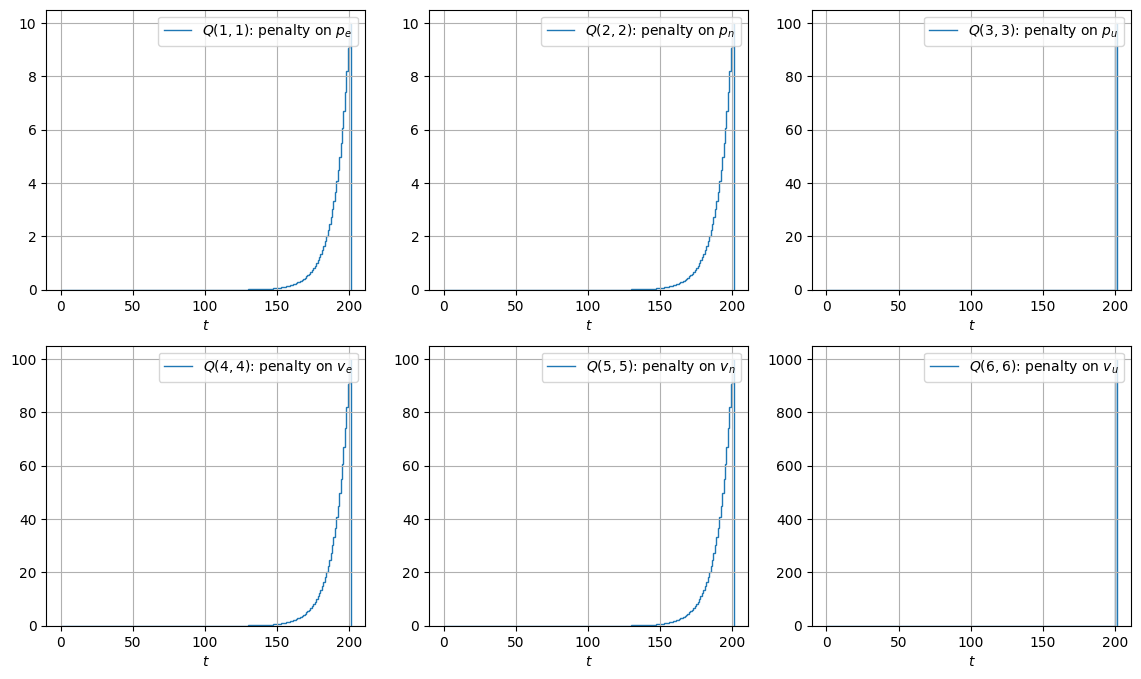

In [4]:
Q = []
R = []
Q_tilde = []
R_tilde = []
for t in range(N):
  Qt = np.exp(-(N-t)/10)*ssp.diags([10,10,  0,100,100,   0])
  Rt = ssp.eye(m)
  Q.append(Qt)
  R.append(Rt)
Q.append(ssp.diags([ 10,10,100,100,100,1000]))

labels = [r'$p_e$',r'$p_n$',r'$p_u$',r'$v_e$',r'$v_n$',r'$v_u$',
          r'$u_e$',r'$u_n$',r'$u_u$']

plt.figure(figsize=(14,8), dpi=100)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.stairs([q.toarray()[i,i] for q in Q], label=rf'$Q({i+1},{i+1})$: penalty on {labels[i]}')
  plt.legend()
  plt.grid()
  plt.xlabel(r'$t$')
plt.show()

In [6]:
# Q

In [3]:
# draw plots
def draw_plots(t1,x1,u1,t2=[],x2=[],u2=[]):
  # t1: time, (N+1,)-vector
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # t2, x2, u2: optional for comparing two trajectories, size same as above

  labels = [r'$p_e$',r'$p_n$',r'$p_u$',r'$v_e$',r'$v_n$',r'$v_u$',
            r'$u_e$',r'$u_n$',r'$u_u$']
  plt.figure(figsize=(14,9), dpi=100)
  for i in range(6):
    plt.subplot(3,3,i+1)
    plt.plot(t1,x1[i],label=labels[i])
    if len(t2):
      plt.plot(t2,x2[i])
    plt.legend()
    plt.grid()
  for i in range(3):
    plt.subplot(3,3,i+7)
    plt.plot(t1[:-1],u1[i],label=labels[i+6])
    if len(t2):
      plt.plot(t2[:-1],u2[i])
    plt.xlabel(r'$t$')
    plt.legend()
    plt.grid()
  plt.show()
  return

# draw 3D plot
def draw_3d_traj(x1,u1,x2=[],u2=[]):
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # x2, u2: optional for comparing two trajectories, size same as above

  fig = plt.figure(figsize=(10,10), dpi=100)
  ax  = fig.add_subplot(projection='3d')
  ax.view_init(elev=10, azim=-75, roll=0)
  _ = 10

  N = x1.shape[1]-1
  ax.plot(*x1[:3,:])
  if len(x2):
    ax.plot(*x2[:3,:])
  for i in range(0, N, 10):
    __ = np.linalg.norm(u1[:,i])/200
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],-u1[0,i]*_,-u1[1,i]*_,-u1[2,i]*_, \
              color='magenta', linewidths=1, arrow_length_ratio = 0)
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],u1[0,i]/__,u1[1,i]/__,u1[2,i]/__, \
              color='gray', linewidths=1, arrow_length_ratio = 0)
    if len(x2):
      __ = np.linalg.norm(u2[:,i])/200
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],-u2[0,i]*_,-u2[1,i]*_,-u2[2,i]*_, \
                color='red', linewidths=1, arrow_length_ratio = 0)
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],u2[0,i]/__,u2[1,i]/__,u2[2,i]/__, \
                color='black', linewidths=1, arrow_length_ratio = 0)

  th = np.linspace(0,2*np.pi)
  ax.plot(100*np.cos(th),100*np.sin(th),0,alpha=0.5,color='green')
  ax.plot(200*np.cos(th),200*np.sin(th),0,alpha=0.5,color='green')
  ax.set_xlabel(r'$p_e$')
  ax.set_ylabel(r'$p_n$')
  ax.set_zlabel(r'$p_u$')
  ax.axis('equal')
  plt.show()
  return

In [5]:
from celluloid import Camera
from matplotlib import rc

def make_3d_anim(x1,u1,x2=[],u2=[],playback_speed=2):
  # x1: state trajectory, 6x(N+1) matrix
  # u1: control vector, 3xN matrix
  # x2, u2: optional for comparing two trajectories, size same as above

  fig = plt.figure(figsize=(10,10), dpi=100)
  ax = fig.add_subplot(projection='3d')
  ax.view_init(elev=10, azim=-75, roll=0)
  _ = 10

  N = x1.shape[1]-1
  camera = Camera(fig)
  for i in range(0,N,playback_speed):
    ax.plot(*x1[:3,:], alpha=0.2)
    if len(x2):
      ax.plot(*x2[:3,:], alpha=0.2)
    __ = np.linalg.norm(u1[:,i])/200
    ax.plot(x1[0,:i+1],x1[1,:i+1],x1[2,:i+1])
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],-u1[0,i]*_,-u1[1,i]*_,-u1[2,i]*_, \
              color='magenta', linewidths=2, arrow_length_ratio = 0)
    ax.quiver(x1[0,i],x1[1,i],x1[2,i],u1[0,i]/__,u1[1,i]/__,u1[2,i]/__, \
              color='gray', linewidths=4, arrow_length_ratio = 0)
    if len(x2):
      __ = np.linalg.norm(u2[:,i])/200
      ax.plot(x2[0,:i+1],x2[1,:i+1],x2[2,:i+1])
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],-u2[0,i]*_,-u2[1,i]*_,-u2[2,i]*_, \
                color='red', linewidths=2, arrow_length_ratio = 0)
      ax.quiver(x2[0,i],x2[1,i],x2[2,i],u2[0,i]/__,u2[1,i]/__,u2[2,i]/__, \
                color='black', linewidths=4, arrow_length_ratio = 0)

    th = np.linspace(0,2*np.pi)
    ax.plot(100*np.cos(th),100*np.sin(th),0,alpha=0.5,color='green')
    ax.plot(200*np.cos(th),200*np.sin(th),0,alpha=0.5,color='green')
    ax.set_xlabel(r'$p_e$')
    ax.set_ylabel(r'$p_n$')
    ax.set_zlabel(r'$p_u$')
    ax.axis( 'equal')

    camera.snap()

  plt.close()
  anim = camera.animate(blit=False, interval=100)
  rc('animation', html='jshtml')
  return anim

(Problem 1) Find the optimal maneuver acceration for the above LQR problem via least squares solutions. Report the terminal position and the terminal velocity at touchdown.

In [30]:
# LQR via least-squares 방식 이용
# X = G*U + H*xo

# state trajactory
X = np.zeros((6, 1))

# G matrix 작성
G = np.array([[0, 0, 0, 0, 0],
            [B, 0, 0, 0, 0],
            [A * B, B, 0, 0, 0],
            [A**2 * B, A * B, B, 0, 0],
            [A**3 * B, A**2 * B, A * B, B, 0],
            [A**4 * B, A**3 * B, A**2 * B, A * B, B]])

# u matrix 작성
U = np.zeros((5,1))

# H matrix 작성
H = np.array([[np.eye(6)],
              [A],
              [A**2],
              [A**3],
              [A**4]])

c:\Users\leeyj\venv\unity_venv\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [35]:
G

array([[0, 0, 0, 0, 0],
       [<6x3 sparse matrix of type '<class 'numpy.float64'>'
        	with 6 stored elements in COOrdinate format>       , 0, 0, 0, 0],
       [<6x3 sparse matrix of type '<class 'numpy.float64'>'
        	with 6 stored elements in Compressed Sparse Row format>,
        <6x3 sparse matrix of type '<class 'numpy.float64'>'
        	with 6 stored elements in COOrdinate format>       , 0, 0, 0],
       [<6x3 sparse matrix of type '<class 'numpy.float64'>'
        	with 6 stored elements in Compressed Sparse Row format>,
        <6x3 sparse matrix of type '<class 'numpy.float64'>'
        	with 6 stored elements in Compressed Sparse Row format>,
        <6x3 sparse matrix of type '<class 'numpy.float64'>'
        	with 6 stored elements in COOrdinate format>       , 0, 0],
       [<6x3 sparse matrix of type '<class 'numpy.float64'>'
        	with 6 stored elements in Compressed Sparse Row format>,
        <6x3 sparse matrix of type '<class 'numpy.float64'>'
        

In [31]:
# Test = np.array([[1,2],[3,4],[4,5]])
# Test[0][0]

In [34]:
# X = G*U + H*X[0]

(Problem 2) Find the optimal maneuver acceration for the above LQR problem by Riccati recursion via dynamic programming. Compare your solution with the least squares solution obtained from above.

In [ ]:
# t1: time, (N+1,)-vector
# x1: state trajectory, 6x(N+1) matrix
# u1: control vector, 3xN matrix
# t2, x2, u2: optional for comparing two trajectories, size same as above

